# Detecting Forgeries of Bob Ross Painting using Convolution Neural Networks

Bob Ross was one of the most prolific painters from the 20th Century. He

In [3]:
import pandas as pd
import os

# Load in the images

In [4]:
bob_directory = 'data/images/all_images/bob/'
bob_imgs = os.listdir(bob_directory)

not_bob_directory = 'data/images/all_images/not_bob/'
not_bob_imgs = os.listdir(not_bob_directory)

In [5]:
def create_title(x):
    try:
        return x.split('_')[0]
    except:
        return x
    
def create_df(images, directory, bob=False):
    df = pd.DataFrame(images)
    df.columns = ['filename']
    df['title'] = df['filename'].apply(create_title)
    df['filetype'] = df['filename'].apply(lambda x: x.split('.')[-1])
    df['fullpath'] = directory + df['filename']
    if bob:
        df['target'] = 'bob'
    else:
        df['target'] = 'not_bob'
    
    return df

bob_df = create_df(bob_imgs, bob_directory, bob=True)
not_bob_df = create_df(not_bob_imgs, not_bob_directory)

In [6]:
bob_df.head()

,filename,title,filetype,fullpath,target
0,cabin-hideaway_5390.png,cabin-hideaway,png,data/images/all_images/bob/cabin-hideaway_5390...,bob
1,autumn-mountain_405.png,autumn-mountain,png,data/images/all_images/bob/autumn-mountain_405...,bob
2,forest-hills_3676.png,forest-hills,png,data/images/all_images/bob/forest-hills_3676.png,bob
3,towering-glacier_4316.png,towering-glacier,png,data/images/all_images/bob/towering-glacier_43...,bob
4,mountain-serenity_10523.jpg,mountain-serenity,jpg,data/images/all_images/bob/mountain-serenity_1...,bob


In [7]:
not_bob_df.head()

,filename,title,filetype,fullpath,target
0,northern-lights_3366.jpg,northern-lights,jpg,data/images/all_images/not_bob/northern-lights...,not_bob
1,golden-glow_4439.jpg,golden-glow,jpg,data/images/all_images/not_bob/golden-glow_443...,not_bob
2,double-oval-stream_6438.jpg,double-oval-stream,jpg,data/images/all_images/not_bob/double-oval-str...,not_bob
3,red-sunset_3599.jpg,red-sunset,jpg,data/images/all_images/not_bob/red-sunset_3599...,not_bob
4,blue-winter_7250.jpg,blue-winter,jpg,data/images/all_images/not_bob/blue-winter_725...,not_bob


In [18]:
all_bob = pd.concat([bob_df, not_bob_df]).reset_index(drop=True)

In [19]:
all_bob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  10591 non-null  object
 1   title     10591 non-null  object
 2   filetype  10591 non-null  object
 3   fullpath  10591 non-null  object
 4   target    10591 non-null  object
dtypes: object(5)
memory usage: 413.8+ KB


In [20]:
all_bob.filetype.value_counts()

jpg     10152
png       408
webp       30
jpeg        1
Name: filetype, dtype: int64

# EDA

In [21]:
print(f'''Bob Ross: Authentic vs. Not - Class Sizes

{all_bob.target.value_counts()}

{all_bob.target.value_counts(normalize=True)}
      ''')

Bob Ross: Authentic vs. Not - Class Sizes

not_bob    10090
bob          501
Name: target, dtype: int64

not_bob    0.952696
bob        0.047304
Name: target, dtype: float64
      


- similarity in image data between targets
- color analysis per class


In [132]:
from PIL import Image
import PIL
import numpy as np
from matplotlib import pyplot as plt

In [30]:
def entropy(signal):
        '''
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent


def plot_entropy(path):    
    colorIm=Image.open(path)
    greyIm=colorIm.convert('L')
    colorIm=np.array(colorIm)
    greyIm=np.array(greyIm)

    N=5
    S=greyIm.shape
    E=np.array(greyIm)
    for row in range(S[0]):
            for col in range(S[1]):
                    Lx=np.max([0,col-N])
                    Ux=np.min([S[1],col+N])
                    Ly=np.max([0,row-N])
                    Uy=np.min([S[0],row+N])
                    region=greyIm[Ly:Uy,Lx:Ux].flatten()
                    E[row,col]=entropy(region)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(colorIm)

    plt.subplot(1,3,2)
    plt.imshow(greyIm, cmap=plt.cm.gray)

    plt.subplot(1,3,3)
    plt.imshow(E, cmap=plt.cm.jet)
    plt.xlabel('Entropy in 10x10 neighbourhood')
    plt.colorbar()

    plt.show()

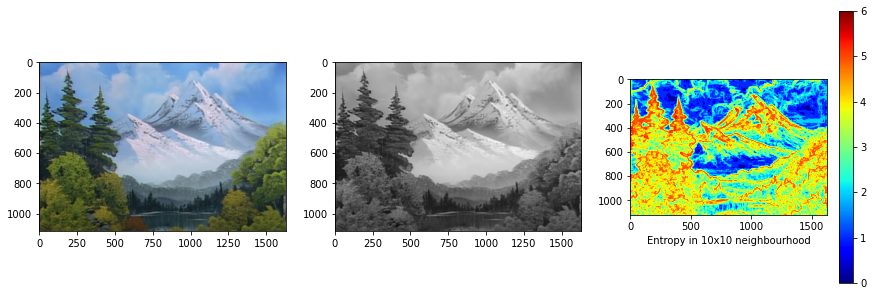

In [61]:
plot_entropy(bob_df.loc[499, 'fullpath'])

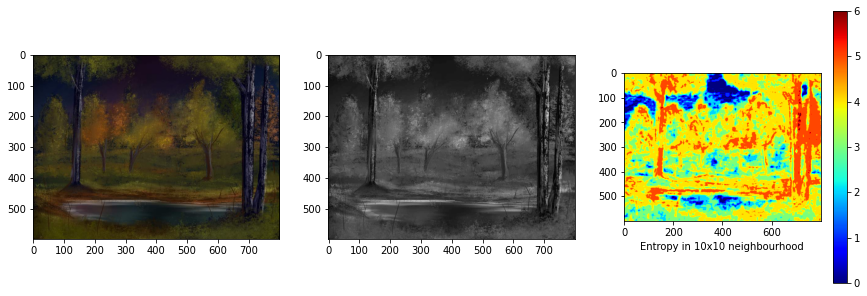

In [58]:
plot_entropy(not_bob_df.loc[37, 'fullpath'])

In [63]:
entropies = []
for i in range(500):
    img = np.array(Image.open(bob_df.loc[i, 'fullpath']).convert('L')).flatten()
    entropies.append((entropy(img), bob_df.target[i], i))
    
for i in range(500):
    img = np.array(Image.open(not_bob_df.loc[i, 'fullpath']).convert('L')).flatten()
    entropies.append((entropy(img), not_bob_df.target[i], i))

In [71]:
entropy_df = pd.DataFrame(entropies)
entropy_df.columns = ['entropy', 'target', 'index']

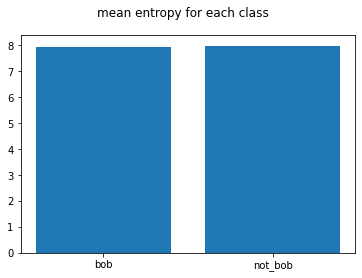

In [79]:
plt.bar(x='target', height='entropy', data=entropy_df)
plt.suptitle('mean entropy for each class')
plt.show()

In [189]:
img_dataset_df = all_bob.groupby('target').sample(len(bob_df), random_state=42).sample(frac=1, random_state=42)

In [190]:
img_dataset_df

,filename,title,filetype,fullpath,target
1214,misty-rolling-hills_3141.jpg,misty-rolling-hills,jpg,data/images/all_images/not_bob/misty-rolling-h...,not_bob
8913,change-of-seasons_7023.jpg,change-of-seasons,jpg,data/images/all_images/not_bob/change-of-seaso...,not_bob
812,mountain-by-the-sea_3770.jpg,mountain-by-the-sea,jpg,data/images/all_images/not_bob/mountain-by-the...,not_bob
2826,campers-haven_6580.jpg,campers-haven,jpg,data/images/all_images/not_bob/campers-haven_6...,not_bob
161,winter-cabin_2809.png,winter-cabin,png,data/images/all_images/bob/winter-cabin_2809.png,bob
...,...,...,...,...,...
301,christmas-eve-snow_5896.png,christmas-eve-snow,png,data/images/all_images/bob/christmas-eve-snow_...,bob
183,reflections-of-calm_10274.png,reflections-of-calm,png,data/images/all_images/bob/reflections-of-calm...,bob
3946,silent-forest_7688.jpg,silent-forest,jpg,data/images/all_images/not_bob/silent-forest_7...,not_bob
52,ab0108384c4ca304de669aed831d5bf1_grande.webp,ab0108384c4ca304de669aed831d5bf1,webp,data/images/all_images/bob/ab0108384c4ca304de6...,bob


# Train Test Split

In [227]:
train_test_split = 0.8
split_index = int(len(img_dataset_df)*train_test_split)
split_index
train_df = img_dataset_df[:split_index]
test_df = img_dataset_df[split_index:]

In [232]:
train_df.target.value_counts()

not_bob    401
bob        400
Name: target, dtype: int64

In [230]:
test_df.target.value_counts()

bob        101
not_bob    100
Name: target, dtype: int64

In [238]:
#resize to same shape for every image


num_images_per_image = 10

img_width = 256
img_height = 256


full_img_height = 256*num_images_per_image
full_img_width = 256*num_images_per_image

img_ratio = 2

def slice_image(row, folder_path):
    try:
        os.mkdir(folder_path)
        os.mkdir(folder_path+'/'+'bob')
        os.mkdir(folder_path+'/'+'not_bob')
    except :
        pass
        
    
    test_img = Image.open(row.fullpath).resize((full_img_height, full_img_width), PIL.Image.BICUBIC)
    test_img_array = np.array(test_img)
    height_stride = test_img_array.shape[0] //num_images_per_image*img_ratio
    width_stride = test_img_array.shape[1] //num_images_per_image*img_ratio
    img_entropy = []
    for i in range(num_images_per_image):
        for j in range(num_images_per_image):
            img_slice = test_img_array[i*height_stride:i*height_stride+height_stride, j*width_stride:j*width_stride+width_stride]
            slice_entropy = entropy(img_slice.flatten())
            img_entropy.append((slice_entropy, i, j, img_slice))
    top_entropies = np.array(sorted(img_entropy, reverse=True))[:num_images_per_image,3]
    for i in range(num_images_per_image):
        Image.fromarray(top_entropies[i]).save(f'{folder_path}/{row.target}/{row.filename.split(".")[0]}_{i}.jpg')

In [239]:
train_directory = 'data/images/train'
val_directory = 'data/images/test'

train_df.apply(slice_image, folder_path='data/images/train', axis=1)
test_df.apply(slice_image, folder_path='data/images/test', axis=1)

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_32393/3447895244.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top_entropies = np.array(sorted(img_entropy, reverse=True))[:num_images_per_image,3]
/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_32393/3447895244.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top_entropies = np.array(sorted(img_entropy, reverse=True))[:num_images_per_image,3]


7303    None
5243    None
1684    None
6678    None
3556    None
        ... 
301     None
183     None
3946    None
52      None
19      None
Length: 201, dtype: object

# Build Dataset

In [241]:
import tensorflow as tf

batch_size = 32

img_width = 256
img_height = 256

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                    )

Found 7970 files belonging to 2 classes.
Using 6376 files for training.
Metal device set to: Apple M1 Pro
Found 2010 files belonging to 2 classes.
Using 402 files for validation.


2022-08-04 14:58:11.286650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-04 14:58:11.287114: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [249]:
def augment_using_ops(images, labels):
    scale=1./255
    images=images*scale
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    return (images, labels)

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Conv2D(input_shape=(img_height, img_width, 3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=512,activation="relu"),
    Dense(units=1, activation='sigmoid')
])



steps_per_epoch = len(train_ds)

validation_steps = len(val_ds)

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

hist = model.fit(train_ds.repeat(),
                        steps_per_epoch=steps_per_epoch,
                        epochs=100,
                        validation_data=val_ds,
                        validation_steps=validation_steps)

Epoch 1/100


2022-08-04 15:39:44.870199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.5993 - acc: 0.7048

2022-08-04 15:41:56.346834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 134s 613ms/step - loss: 0.5993 - acc: 0.7048 - val_loss: 0.3566 - val_acc: 0.8930
Epoch 2/100
200/200 [==============================] - 126s 606ms/step - loss: 0.3804 - acc: 0.8530 - val_loss: 0.2667 - val_acc: 0.8905
Epoch 3/100
200/200 [==============================] - 125s 600ms/step - loss: 0.3047 - acc: 0.8912 - val_loss: 0.2480 - val_acc: 0.9129
Epoch 4/100
200/200 [==============================] - 124s 598ms/step - loss: 0.2715 - acc: 0.8996 - val_loss: 0.2827 - val_acc: 0.9005
Epoch 5/100
200/200 [==============================] - 125s 599ms/step - loss: 0.2558 - acc: 0.9079 - val_loss: 0.2414 - val_acc: 0.9080
Epoch 6/100
200/200 [==============================] - 126s 604ms/step - loss: 0.2385 - acc: 0.9120 - val_loss: 0.2187 - val_acc: 0.9229
Epoch 7/100
200/200 [==============================] - 125s 603ms/step - loss: 0.2050 - acc: 0.9202 - val_loss: 0.2148 - val_acc: 0.9179
Epoch 8/100
200/200 [==============================] 

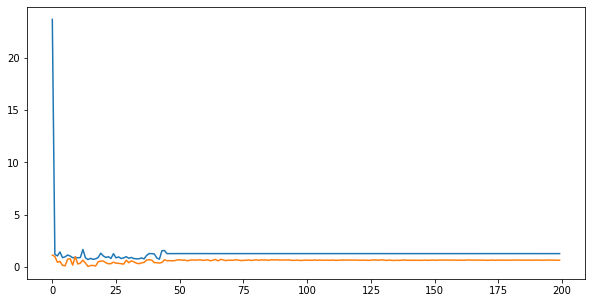

In [152]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'])
plt.show()

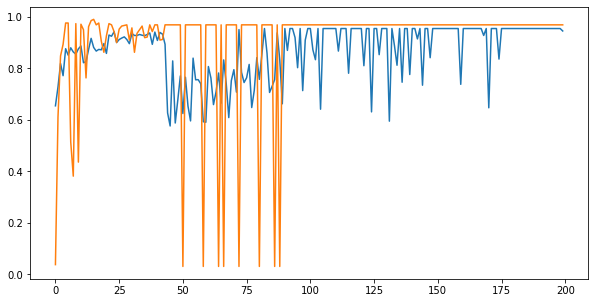

In [153]:
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['acc'])), hist.history['acc'])
plt.plot(range(len(hist.history['val_acc'])), hist.history['val_acc'])
plt.show()